In [30]:
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable, grad
from torch.nn.functional import binary_cross_entropy_with_logits as bce
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import sys
import time
import numpy as np
import cPickle as pickle
from IPython.display import Image
from power_spec import *
from models import *

In [2]:
def draw_true_samples(nsamp, samp_type, *argv):
    '''For 2d_gaussian, *argv arguments are mu_0, mu_1, sig_1, sig_2, rho'''
    if samp_type=='2d_gaussian':
        mus = np.array([argv[0], argv[1]])
        sigs = [argv[2], argv[3]]
        rho = argv[4]
        cov = np.array([[sigs[0]**2, rho*sigs[0]*sigs[1]],[rho*sigs[0]*sigs[1], sigs[1]**2]])
        s = torch.from_numpy(np.random.multivariate_normal(mus, cov, nsamp))
    
    elif samp_type=='1d_gaussian':
        mu = argv[0]
        sig = argv[1]
        s = torch.from_numpy(np.random.normal(mu, sig, nsamp))
    
    elif samp_type=='bernoulli':
        n = argv[0]
        p = argv[1]
        s = torch.from_numpy(np.random.binomial(n, p, nsamp))
    
    ''' ring returns samples from equally spaced points around a circle with some scatter '''
    elif samp_type == 'ring':
        k = argv[0]
        std = argv[1]
        m = means_circle(k)
        i = torch.zeros(nsamp).random_(m.size(0)).long()
        s = torch.randn(nsamp, 2) * std + m[i]
    
    ''' grid returns samples from equally spaced points on a grid with some scatter. only seems to work for odd numbers '''
    elif samp_type == 'grid':
        k = argv[0]
        std = argv[1]
        m = means_grid(k)
        i = torch.zeros(nsamp).random_(m.size(0)).long()
        print i
        s = torch.randn(nsamp, 2) * std + m[i]

    ''' noise returns samples of standard normal noise which is used by the generator'''
    elif samp_type=='noise':
        n_latent = argv[0]
        s = torch.randn(nsamp, n_latent)

    return s

def means_circle(k=8):
    p = 3.14159265359
    t = torch.linspace(0, 2 * p - (2 * p / k), k)
    m = torch.cat((torch.sin(t).view(-1, 1),torch.cos(t).view(-1, 1)), 1)
    return m

def means_grid(k=25):
    m = torch.zeros(k, 2)
    s = int(torch.sqrt(torch.Tensor([k]))[0] / 2)
    cnt = 0
    for i in xrange(-s, s + 1):
        for j in xrange(-s, s + 1):
            m[cnt][0] = i
            m[cnt][1] = j
            cnt += 1
    return m / s

SyntaxError: invalid syntax (<ipython-input-2-92b1ccf086e1>, line 21)

In [ ]:
LCDM = dict({'Om_b_h2':[0.02, 0.00014], 'Om_c_h2':[0.1188, 0.001], 't0':[13.799e9, 0.021e9], 'ns':[0.9667, 0.004], 'delta_r_2':[2.441e-9, 0.09e-9], 'tau':[0.066, 0.012]})

def sample_LCDM():
    params = []
    for key in LCDM:
        print key
        print LCDM[key][0], LCDM[key][1]
        params.append(np.random.normal(LCDM[key][0], LCDM[key][1]))
    
    print 'params'
    print params
sample_LCDM()

In [27]:
# class Perceptron(torch.nn.Module):
#     def __init__(self, sizes, final=None):
#         super(Perceptron, self).__init__()
#         layers = []
#         for i in range(len(sizes) - 1):
#             layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
#             if i != (len(sizes) - 2):
#                 layers.append(torch.nn.ReLU())
#         if final is not None:
#             layers.append(final())
#         self.net = torch.nn.Sequential(*layers)

#     def forward(self, x):
#         return self.net(x)

class Perceptron(torch.nn.Module):
    def __init__(self, sizes, activation='ReLU', final=None):
        super(Perceptron, self).__init__() # what does this line do?
        print 'activation:', activation
        layers = []
        for i in xrange(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i != (len(sizes) - 2):
                if activation=='ReLU':
                    layers.append(torch.nn.ReLU())
                elif activation=='LeakyReLU':
                    layers.append(torch.nn.LeakyReLU()) # leaky relu, alpha=0.01
                elif activation=='ELU':
                    layers.append(torch.nn.ELU())
                elif activation=='PReLU':
                    layers.append(torch.nn.PReLU())

        if final is not None:
            layers.append(final())
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)
   
    
def sample_noise(bs, d):
    z = torch.randn(bs, d).float()
    return Variable(z.to(Device), requires_grad=True)
    
def restore_nn(filepath):
    # get config parameters from run and use to construct Perceptron object
    filen = open(filepath+'/params.txt','r')
    pdict = pickle.load(filen)
    try:
        model = Perceptron([pdict['latent_dim']+pdict['n_cond_params']] + [pdict['n_hidden']] * pdict['n_layers'] + [pdict['n_out']], pdict['activation'])
    except:
        model = Perceptron([pdict['latent_dim']+pdict['n_cond_params']] + [pdict['n_hidden']] * pdict['n_layers'] + [pdict['n_out']])
    model.load_state_dict(torch.load(filepath+'/netG'))
    model.eval()
    
    return model, pdict

In [14]:
from scipy import stats

basedir = '/Users/richardfeder/Documents/caltech/gan_work/results/'
mutrue, stdtrue = 3.4, 0.5

def generate_samples(G, pdict, nsamp, cond_params=None):
    arr = np.zeros((nsamp, pdict['n_out']))
    
    z = torch.randn(nsamp, pdict['latent_dim']).float()
    
    gen_input = torch.from_numpy(np.tile(cond_params, (nsamp, 1))).float()
    gen_input = torch.cat((z, gen_input), 1)
    out = G(gen_input)
    
    arr = out.detach().numpy()
            
    return arr

def make_comparison_plot(true, fake, ks=None, save=None):
    muf, stdf = np.mean(fake), np.std(fake)
    print muf, stdf
    
    plt.figure()
    if ks is not None:
        plt.title('KS Statistic D = '+ str(np.round(ks.statistic, 5)))
    _, bins, _ = plt.hist(true, histtype='step', label='True', bins=20)
    plt.hist(fake, histtype='step', bins=bins, label='Generated')
    plt.legend()
    if save is not None:
        plt.savefig(save+'.png', bbox_inches='tight')
    plt.show()
    

''' Kolmogorov-Smirnov Test on True vs. Generated Samples. This test only applies to 1D distributions. 

    Inputs: 
        gen_array (N,) -- an ndarray with samples from the generator
        cond_params (n_cond,) -- a list of length n_cond specifying conditional parameters of distribution denoted by samp_type
        samp_type -- a str specifying type of distribution to sample
        
    Output:
        ks -- an object with KS statistic and p-value (D, p)
'''
def ks_test(gen_array, cond_params, samp_type='norm'):
    if samp_type=='norm':
        ks = stats.ks_2samp(np.random.normal(cond_params[0], cond_params[1], 100000), arr)
#         ks = stats.kstest(arr, lambda x: stats.norm.cdf(x, loc=cond_params[0], scale=cond_params[1]))
#     print ks
    return ks

def kl_divergence(gen_array, cond_params, samp_type='norm'):
    if samp_type =='norm':
        true = np.random.normal(cond_params[0], cond_params[1], 10000)
    
    true_hist, bins = np.histogram(true, density=True)
    gen_hist, _ = np.histogram(gen_array, density=True, bins=bins)

    kl = stats.entropy(true_hist+1e-5, gen_hist+1e-5)
    return kl
        


def test_cGAN(timestr, cond_params=None, nsamp=10000):
    netG, pdict = restore_nn(basedir+timestr)
    print pdict
    if cond_params is None:
        cond_params = [mutrue, stdtrue]
    print 'Conditional parameters:', cond_params
    arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
    ks = ks_test(arr, cond_params)
    kl = kl_divergence(arr, cond_params)
    real = np.random.normal(cond_params[0], cond_params[1], nsamp)
    frame_dir = basedir+timedir+'/frames/'+str(cond_params[0])+'_'+str(cond_params[1])
    make_comparison_plot(real, arr, ks=ks, save=frame_dir)
    

# test_cGAN('20190123-150922', cond_params=[1.5, 1.5])

In [7]:
def ks_test_cGAN(timestr, vals, nsamp=1000, plot=True, save=False):
    netG, pdict = restore_nn(basedir+timestr)
    
    Ds = []
    ps = []
    KL = []
    mus, sigs = [], []
    for val in vals:
        cond_params = [0.0, val]
#         cond_params = [val, 1.0]
        arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
        mus.append(np.mean(arr))
        sigs.append(np.std(arr))
        ks = ks_test(arr, cond_params)
        kl = kl_divergence(arr, cond_params)
        Ds.append(ks.statistic)
        ps.append(ks.pvalue)
        KL.append(kl)
        
        real = np.random.normal(cond_params[0], cond_params[1], arr.shape[0])
        frame_dir = basedir+timestr+'/frames/'+str(cond_params[0])+'_'+str(cond_params[1])
        make_comparison_plot(real, arr, ks=ks, save=frame_dir)
    
        
    if plot:
        plt.figure()
        plt.plot(vals, Ds, marker='o')
        plt.axhline(1.36/np.sqrt(1000), linestyle='dashed', label='$D_{crit}$ (95 percent)')
        plt.xlabel('$\sigma$')
#         plt.xlabel('$\mu$')
        plt.ylim(0, 1)
        plt.ylabel('KS Statistic')
        plt.legend()
        if save:
#             plt.savefig(basedir+timestr+'/kstest_mus.png', bbox_inches='tight')
            plt.savefig(basedir+timestr+'/kstest_sig_mu=0.0.png', bbox_inches='tight')
        plt.show()
        
        plt.figure()
        plt.plot(vals, KL, marker='o')
        plt.xlabel('$\sigma$')
#         plt.xlabel('$\mu$')
        plt.ylabel('KL Divergence Statistic')
        plt.legend()
        if save:
#             plt.savefig(basedir+timestr+'/KLDivTest_mus.png', bbox_inches='tight')
            plt.savefig(basedir+timestr+'/KLDivTest_sig_mu=0.0.png', bbox_inches='tight')
        plt.show()
        
#         plt.figure(figsize=(9, 4))
#         plt.subplot(1,2,1)
#         plt.plot(vals, vals, label='Truth')
#         plt.plot(vals, mus, label='Generated')
# #         plt.plot(vals, sigs, label='Generated')
#         plt.xlabel('$\mu$ used in conditioning')
#         plt.ylabel('$\mu$ estimated')
# #         plt.xlabel('$\sigma$ used in conditioning')
# #         plt.ylabel('$\sigma$ estimated')
#         plt.legend()
        
#         plt.subplot(1,2,2)
#         plt.axhline(1.0)
#         plt.plot(vals, sigs, label='Generated')
# #         plt.plot(vals, mus, label='Generated')
#         plt.ylabel('$\sigma$ estimated')
#         plt.xlabel('$\mu$ used in conditioning')
# #         plt.ylabel('$\mu$ estimated')
# #         plt.xlabel('$\sigma$ used in conditioning')
#         if save:
#             plt.savefig(basedir+timestr+'/fix_sig_change_mu.png', bbox_inches='tight')
# #             plt.savefig(basedir+timestr+'/fix_mu_change_sig_mu=0.5.png', bbox_inches='tight')

#         plt.show()

        
    return Ds, ps, KL
    
mus = np.linspace(-1, 1, 30)

sigs = np.linspace(0.01, 2, 20)

Ds, ps, KL = ks_test_cGAN('20190123-150922', sigs, save=True)


NameError: global name 'restore_nn' is not defined

In [35]:
cond_params = [0.0, 0.0, 1.1, 0.1, 0.0]
nsamp = 1000

mu_range = np.linspace(-3, 3, 30)
sig_range = np.linspace(0.01, 3, 30)

cond_params = [0.0, 0.0, 1.1, 0.1, 0.0]

cond_param_list = np.zeros((30, len(cond_params)))

for i, mu in enumerate(mu_range):
    cond_param_list[i,:] = cond_params
    cond_param_list[i,1] = mu
    

def compare_nns(timestr_list, labels, idx = 0, idx2s=[0], nsamp=1000, save=False):
    mu_range = np.linspace(-3, 3, 60)
    sig_range = np.linspace(0.01, 4, 60)
#     mu_range = np.linspace(-1, 1, 60)
#     sig_range = np.linspace(0.01, 2, 60)

    nets = []
    pdicts = []
    
    for timestr in timestr_list:
        netG, pd = restore_nn(basedir + timestr)
        nets.append(netG)
        pdicts.append(pd)
    
    if pdicts[0]['sample_type']=='2d_gaussian':
        cond_params = [0.0, 1.0,0.0, 1.0, 0.0]
    elif pdicts[0]['sample_type']=='1d_gaussian':
        cond_params = [0.0, 1.0]

    
    cond_param_list = np.zeros((60, len(cond_params)))
    if idx==0 or idx==2:
        val_array = mu_range # same for correlation coefficient as mu
    elif idx==1 or idx==3:
        val_array = sig_range
    elif idx==4:
        val_array = np.linspace(-1, 1, 60)
    
    for i, val in enumerate(val_array):
        cond_param_list[i,:] = cond_params
        cond_param_list[i,idx] = val
        
    cparams = np.array(cond_param_list)


        
    deduce_params = [np.zeros((cparams.shape[0], len(cparams[0]))) for x in xrange(len(nets))]

    
    for i, cond_params in enumerate(cparams):
        for j in xrange(len(nets)):
            arr = generate_samples(nets[j], pdicts[j], nsamp, cond_params=cond_params)
            if pdicts[j]['sample_type']=='2d_gaussian':
                deduce_params[j][i,:] = np.array([np.mean(arr[:,0]),  np.std(arr[:,0]), np.mean(arr[:,1]), np.std(arr[:,1]), np.cov(arr[:,0], arr[:,1])[0,1]/(np.std(arr[:,0])*np.std(arr[:,1]))])
                pnamelist = ['$\mu_0$', '$\sigma_0$', '$\mu_1$', '$\sigma_1$', 'rho']  
                pnamelist_notex = ['mu_0', 'sigma_0','mu_1','sigma_1', 'rho']
            elif pdicts[j]['sample_type']=='1d_gaussian':
                deduce_params[j][i,:] = np.array([np.mean(arr), np.std(arr)])
                pnamelist = ['$\mu$', '$\sigma$']  
                pnamelist_notex = ['mu', 'sigma']
    

    fig = plt.figure(figsize=(8,12))
    for i, idx2 in enumerate(idx2s):
        plt.subplot(len(idx2s),1, i+1)
        plt.xlabel(pnamelist[idx])
        plt.ylabel(pnamelist[idx2])
#         if idx != idx2:
#             plt.ylim(cparams[0,idx2]-0.2, cparams[0,idx2]+0.2)
        plt.plot(cparams[:,idx], cparams[:,idx2], label='Truth')
        for j in xrange(len(nets)):
            plt.plot(cparams[:,idx], deduce_params[j][:,idx2], label=labels[j])
        if i==0:
            plt.legend()
    if save:
        plt.savefig(basedir+timestr_list[-1]+'/comp_nns_relu_leaky_vary_'+pnamelist_notex[idx]+'_wide.pdf', bbox_inches='tight')
    plt.show()
    
    return fig
        


activation: ReLU
activation: LeakyReLU
activation: ELU
activation: PReLU
activation: PReLU


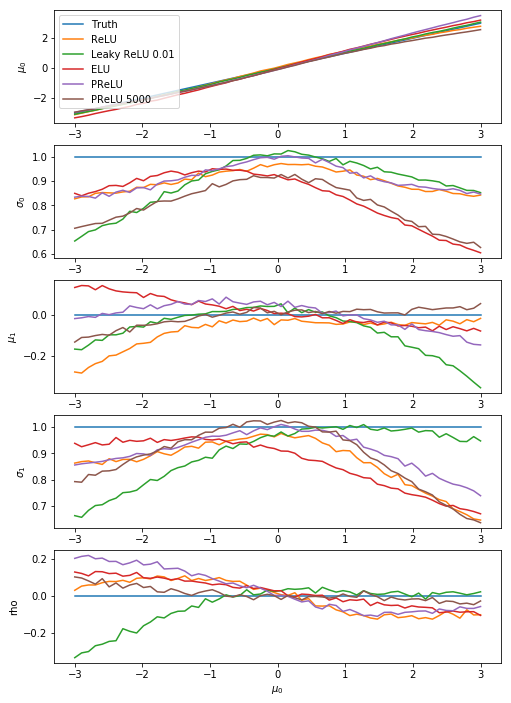

activation: ReLU
activation: LeakyReLU
activation: ELU
activation: PReLU
activation: PReLU


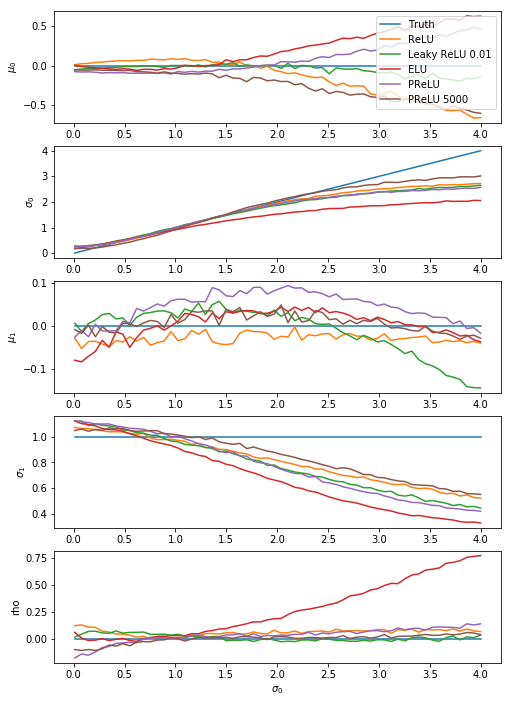

activation: ReLU
activation: LeakyReLU
activation: ELU
activation: PReLU
activation: PReLU


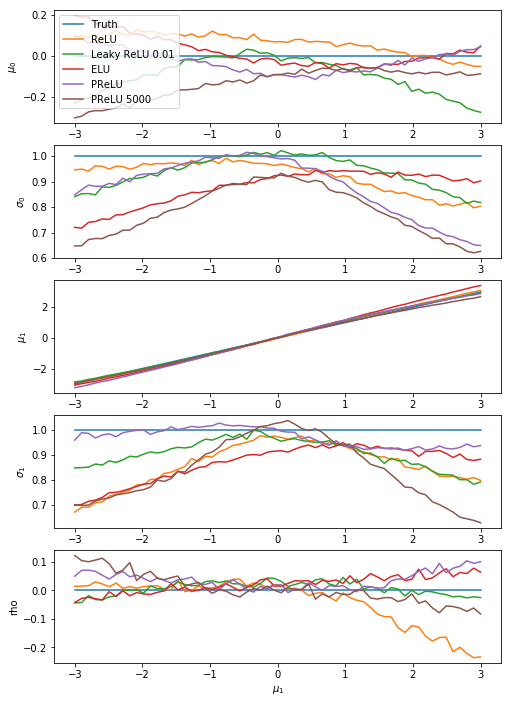

activation: ReLU
activation: LeakyReLU
activation: ELU
activation: PReLU
activation: PReLU


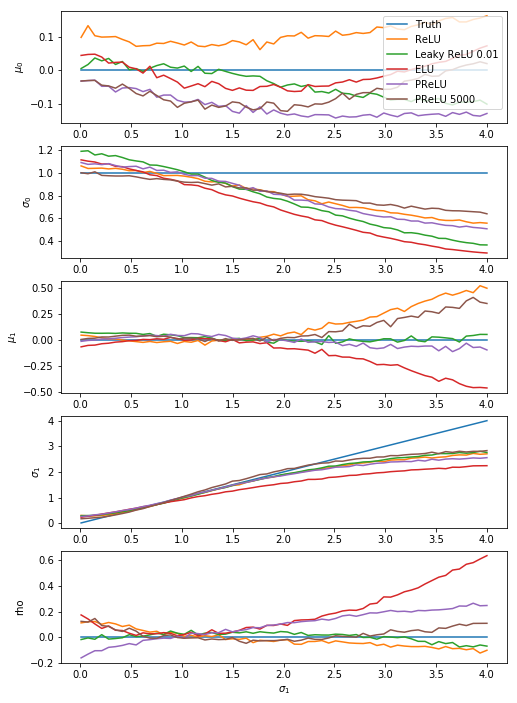

activation: ReLU
activation: LeakyReLU
activation: ELU
activation: PReLU
activation: PReLU


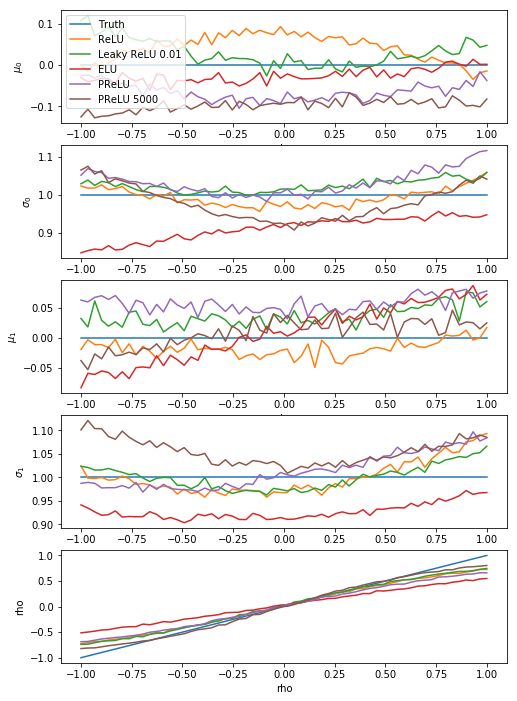

In [36]:
# timestr_list = ['20190126-114321', '20190126-114911', '20190126-124350']
# label_list = ['1d LD=1 NH=32', '1d LD=1 NH=64', 'NH=32 gamma=0.5']

# timestr_list = ['20190125-163106', '20190125-165642', '20190125-162524']
# label_list = ['RGAN 2000 gam=0.5', 'RGAN LD=5 gam=1.0 bs=64', 'RGAN 2000']

# timestr_list = ['20190126-135746', '20190126-135945', '20190126-140142', '20190126-140238']
# label_list = ['LH ngrid=16', 'Unif 4 x 4', 'LH ngrid=64', 'Unif 8 x 8']

# timestr_list = ['20190126-140901', '20190126-141142', '20190126-141703', '20190126-141807']
# label_list = ['LH ngrid=1024', 'Unif 4x4x4x4x4', 'Unif 10x10x10x10x10', 'LH ngrid=1e5']

# timestr_list = ['20190126-142238', '20190126-141807', '20190125-165642']
# label_list = ['Unif 10x10x10x10x10', 'LH ngrid=1e5', 'RGAN LD=5 1.0 bs64']

# timestr_list = ['20190128-110508', '20190128-110812', '20190128-111004'] # 1d gaussian 2000 samples
# label_list = ['8 nmix=4', 'nmix=2', 'nmix=4 LD=1']

# timestr_list = ['20190127-230509', '20190127-231600', '20190127-232322', '20190127-232023']
# label_list = [ 'LD=2', '64 ld=5 3000', 'LH 8', 'Unif 8']

# timestr_list = ['20190127-232322', '20190128-114803', '20190128-115114', '20190128-115615']
# label_list = ['LH 8', '8 nmix=4', '8 nmix=8', 'LH 8 nmix=4'] # these are all 3000 iterations

# timestr_list = ['20190128-115114', '20190128-115615']
# label_list = ['Unif ng=8 nmix=4', 'LH ng=8 nmix=4']

# timestr_list = ['20190128-114803', '20190128-120228', '20190128-162143', '20190128-162737']
# label_list = ['Unif ng=8 nmix=8', 'LH ng=8 nmix=8', 'unif nlayer=2', 'nlayer=1']

# timestr_list = ['20190128-123646', '20190128-120930']
# label_list = ['Unif ng=4 nmix=4', 'LH ng=4 nmix=4']

# timestr_list = ['20190128-114803', '20190128-135155']
# label_list = ['Unif ng=8 nmix=8', 'Unif ng=8 nmix=16']

# timestr_list = ['20190128-162143', '20190129-162328', '20190129-162551', '20190129-162839', '20190129-163107']
# label_list = ['2 layer ReLU','ReLU', 'Leaky ReLU 0.01', 'ELU', 'PReLU']

timestr_list = ['20190129-165309', '20190129-165746', '20190129-170003', '20190129-165524', '20190129-170333']
label_list = ['ReLU', 'Leaky ReLU 0.01', 'ELU', 'PReLU', 'PReLU 5000'] # 2 layer different types

for x in xrange(5):
    fig1 = compare_nns(timestr_list, label_list, idx=x, idx2s=[0, 1, 2, 3, 4], save=True, nsamp=10000)
    
# for x in xrange(2):
#     fig1 = compare_nns(timestr_list, label_list, idx=x, idx2s=[0, 1], save=False, nsamp=10000)


In [23]:
def LHS(array_list):
    d = len(array_list[0])
    LH_samples = np.zeros((d, len(array_list)))
    for i in xrange(d):
        samp = []
        for j in xrange(LH_samples.shape[1]):
            idx = np.random.randint(d-i)
            samp.append(array_list[j][idx])
            array_list[j] = np.delete(array_list[j], [idx])
        LH_samples[i,:] = np.array(samp)

    return LH_samples

In [53]:
a = np.column_stack((np.full(10, 5), np.full(10, 6)))
b = np.column_stack((np.full(10, 7), np.full(10, 8)))

c = np.vstack((a,b))
# print c

In [2]:
def model0(k):
    return k**0*0.5

def gen_2Dgauss(N, Lx, Ly, model):

    field = np.zeros((N,N), dtype = complex)

    dkx = (2.*np.pi)/Lx
    dky = (2.*np.pi)/Ly

    for ix in range(0, N):
        if ix <= N/2:
            kx = ix*dkx
        else:
            kx = (ix-N)*dkx
    
        for iy in range(0, N):
            if iy <= N/2:
                ky = iy*dky
            else:
                ky = (iy-N)*dky
        
            kval = (kx**2 + ky**2)**0.5
        
            field[ix, iy] = np.random.normal(0.,(model(kval)/2.)**0.5) + np.random.normal(0.,(model(kval)/2.)**0.5)*1j

    # Now we have to set \delta(-k) = \delta^*(k)
    # Note that \delta_n = \delta_{n+N} and therefore we have to set \delta(2dk,-dk) = \delta^*(2dk,dk)
    for ix in range(N/2+1, N):
    
        jx = N-ix
    
        field[ix, 0] = field[jx, 0].real - field[jx, 0].imag*1j
        field[0, ix] = field[0, jx].real - field[0, jx].imag*1j

        for iy in range(1, N):
        
            jy = N-iy
        
            field[ix, iy] = field[jx, jy].real - field[jx, jy].imag*1j

    if N % 2 == 0:
        for ix in range(1, N/2):
            jx = N-ix
            
            field[N/2,ix] = field[N/2,jx].real - field[N/2,jx].imag*1j


        kval = dkx*N/2
        # Set the complex part to zero if there is no partner (note the factor of 2 difference)
        field[0,N/2] = np.random.normal(0.,model(kval)**0.5) + 0.*1j;
        field[N/2,0] = np.random.normal(0.,model(kval)**0.5) + 0.*1j;
        
        kval = (dkx*N/2)*(2**0.5)
        
        field[N/2,N/2] = np.random.normal(0.,model(kval)**0.5) + 0.*1j;

    field[0,0] = 0. + 0.*1j
    
    return field

def main():
    
    Lx = 1.
    Ly = 1.
    V = Lx*Ly
    N = 101
    dk = (2.*np.pi)/Lx
    
    #-----------------------------------------#
    #-- Generate Gaussian random field -------#
    #-----------------------------------------#
    
    kspace_field = gen_2Dgauss(N, Lx, Ly, model0)
    
    config_field = np.fft.ifft2(kspace_field)*kspace_field.size**0.5
    
    fig, ax = plt.subplots()
    im = ax.imshow(config_field.real, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)
    plt.title("field.real, config_space")
    plt.show()
    
    plt.figure()
    plt.imshow(abs(kspace_field))
    plt.colorbar()
    plt.show()
    
# main()



In [2]:


def restore_conv_nn(filepath):
    # get config parameters from run and use to construct Perceptron object
    filen = open(filepath+'/params.txt','r')
    pdict = pickle.load(filen)
    model = DC_Generator(pdict['ngpu'], 1, pdict['latent_dim'], pdict['ngf'])
    
    model.load_state_dict(torch.load(filepath+'/netG', map_location='cpu'))
    model.eval()
    
    return model, pdict

def restore_conv_nn_new(filepath):
    # get config parameters from run and use to construct Perceptron object
    filen = open(filepath+'/params.txt','r')
    pdict = pickle.load(filen)
    model = DC_Generator(pdict['ngpu'], 1, pdict['latent_dim'], pdict['ngf'], sizes)
    
    model.load_state_dict(torch.load(filepath+'/netG', map_location='cpu'))
    model.eval()
    
    return model, pdict

In [2]:
# fpath = '/home1/06224/rfederst/gan-work/results/20190227-034155'
fpath2 = '/home1/06224/rfederst/gan-work/results/20190227-221318/'

# fpath3 = '/home1/06224/rfederst/gan-work/results/20190227-225900/'

Image('results/20190227-225900/loss_GD.png') 

gen, pdict = restore_conv_nn(fpath)
nsamp = 1000
z = torch.randn(nsamp, pdict['latent_dim'], 1, 1).float()
# samps = gen(z)
gen_grfs = gen(z).detach().numpy()[:,0,:,:]



NameError: name 'restore_conv_nn' is not defined

(0, 16)
(1, 8)
(2, 4)
(3, 2)
(4, 1)


In [70]:
ndiv = 10
zrange = np.linspace(0, 2, ndiv)
add_range = np.linspace(0.0, 5, ndiv)

for i in xrange(pdict['latent_dim']):
    z = torch.zeros(ndiv, pdict['latent_dim'], 1, 1).float()
z = np.zeros((pdict['latent_dim'], pdict['latent_dim'], 1, 1))


for i in xrange(pdict['latent_dim']-1):
    z[i+1,i+1,0,0] = 1




z = torch.from_numpy(z).float()

# print(z)
z = torch.

gen_grfs = gen(z).detach().numpy()[:,0,:,:]

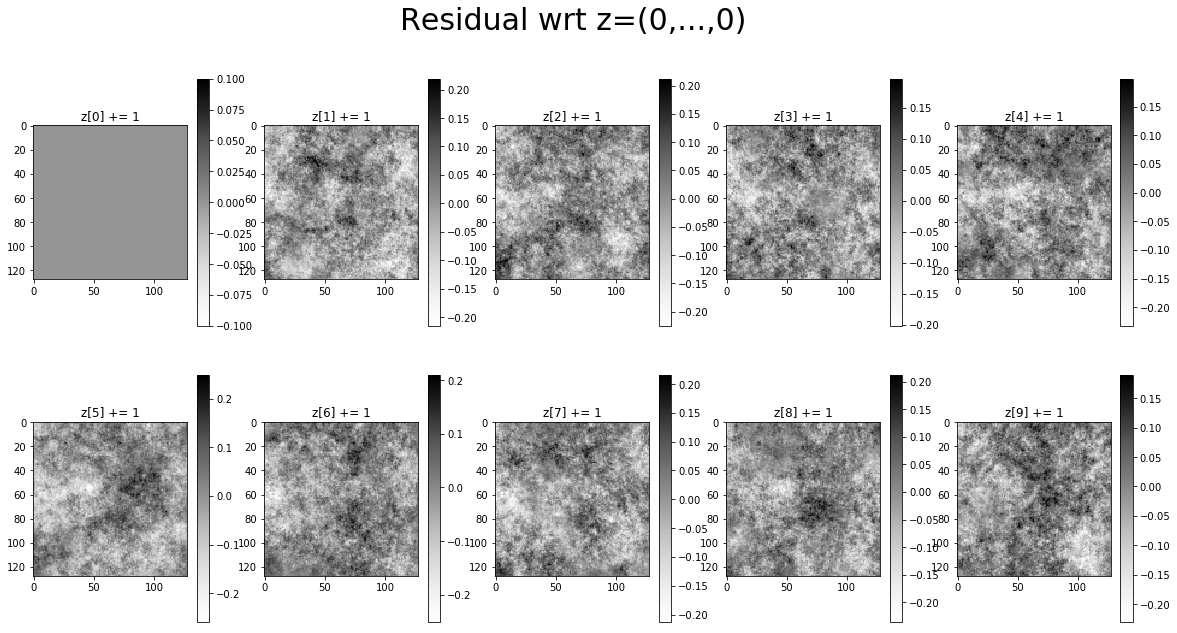

i =  0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Nope


In [16]:

# generate fake GRFs and fit power spectrum
slopes, amps = [], []

plt.figure(figsize=(20, 10))
plt.suptitle('Residual wrt z=(0,...,0)', fontsize=30)
for i in xrange(10):
    plt.subplot(2, 5, i+1)
#     plt.title('z['+i+'] += '+str(np.round(add_range[i], 3)))
#     plt.imshow(gen_grfs[i], interpolation='none')
    plt.title('z['+str(i)+'] += 1')

    plt.imshow(gen_grfs[i]-gen_grfs[0], interpolation='none', cmap='Greys')
    plt.colorbar()
#     print(add_range[i])
    
#     k, bf_line, power_interp, pspec_size = fit_2d_powerspectrum(gen_grfs[i])
#     amps.append(bf_line[0])
#     slopes.append(bf_line[1])
#     plot_powerspec_and_field(k, power_interp, bf_line, gen_grfs[i])

plt.show()   

for i in xrange(1):
    print 'i = ', i
    
#     plt.figure()
#     plt.imshow(gen_grfs[i]-gen_grfs[0], interpolation='none', cmap='Greys')
#     plt.colorbar()
#     plt.show()
    k, bf_line, power_interp, pspec_size = fit_2d_powerspectrum(gen_grfs[i]-gen_grfs[0])
#     print power_interp
    x = power2DMean(k, power_interp, pspec_size)
    print x
    idxs = [i for i,v in enumerate(x) if v > 0.1]
#     print idxs
    if len(idxs) > 0:
        print(idxs, k[idxs])
    else:
        print('Nope')
#     plot_powerspec_and_field(k, power_interp, bf_line, gen_grfs[i]-gen_grfs[0])
# new_grf = gen_grfs[1]-gen_grfs[0]
# k, bf_line, power_interp, pspec_size = fit_2d_powerspectrum(new_grf)
# plot_powerspec_and_field(k, power_interp, bf_line, new_grf)

# # generate true samples and fit power spectrum   
alpha = -2.0
slopes_real, amps_real = [], []
ims = []
ims = gaussian_random_field(1000, alpha, size=128)
# for im in ims:
#     k, line, power_interp, pspec_size = fit_2d_powerspectrum(im)
#     slopes_real.append(line[1])
#     amps_real.append(line[0])
    

    
# slopes = np.array(slopes)
# amps = np.array(amps)  

4096000 1638400


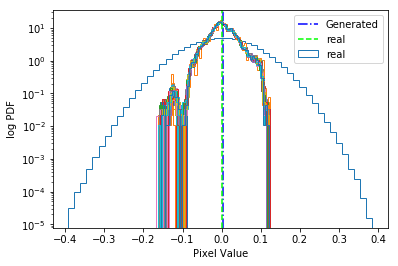

Means:
(0.0024738938, 0.033733584, ' (Generated)')
(-6.9985250233939307e-20, 0.078340379434987312, ' (True)')


In [91]:
print np.size(ims), np.size(gen_grfs)

meangen, stdgen = np.mean(gen_grfs.flatten()), np.std(gen_grfs.flatten())
meantrue, stdtrue = np.mean(ims.flatten()), np.std(ims.flatten())
plt.figure()
# plt.title('Pixel PDFs From 1000 realizations (128 x 128)')
_, bins, _ = plt.hist(ims.flatten(), label='real', histtype='step', bins=50, normed=True)
for i in xrange(gen_grfs.shape[0]):
    plt.hist(gen_grfs[i].flatten(), bins=50, histtype='step', normed=True)

# plt.hist(gen_grfs.flatten(), bins=50, label='Generated', histtype='step', normed=True)
plt.axvline(meangen, label='Generated', linestyle='dashdot', color='b')
plt.axvline(meantrue, label='real', linestyle='dashed', color='lime')
plt.legend()
plt.ylabel('log PDF')
plt.xlabel('Pixel Value')
plt.yscale('log')
# plt.savefig('pixel_pdfs.pdf', bbox_inches='tight')
plt.show()

print('Means:')
print(np.mean(gen_grfs.flatten()),np.std(gen_grfs.flatten()),  ' (Generated)')
print(np.mean(ims.flatten()), np.std(ims.flatten()), ' (True)')


In [9]:
samp_range = np.array([100, 500, 1000, 2000, 3000])
z = torch.randn(1000, pdict['latent_dim'], 1, 1).float()
gen_grfs = gen(z).detach().numpy()[:,0,:,:]    

In [17]:
avs = []
stds = []
for nsamp in samp_range:
    print(nsamp)
    avs.append(np.mean(gen_grfs[:nsamp].flatten()))
    stds.append(np.std(gen_grfs[:nsamp].flatten()))

100
500
1000
2000
3000


Saved 1000 GRF realizations.


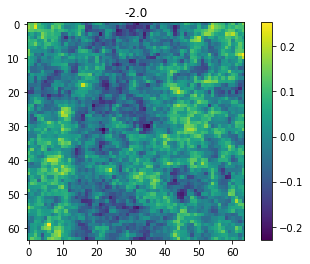

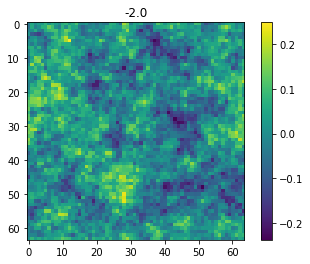

In [19]:
import astropy
from astropy.io import fits
nsamp = 1000
alpha = -2.0
size=128
ims = gaussian_random_field(nsamp, alpha, size=size)


def generate_grf_dataset(nsamp, alpha, size):
    ims = gaussian_random_field(nsamp, alpha, size=size)
    for i, im in enumerate(ims):
        hdr = fits.header.Header()
        hdr['imdim']=size
        hdr['alpha']=alpha
        fits.writeto('data/ps'+str(size)+'/grf_'+str(i)+'.fits', im, hdr, overwrite=True) 
    print('Saved '+str(nsamp)+' GRF realizations.')
        
generate_grf_dataset(nsamp, alpha, size)


class GRFDataset(Dataset):
    def __init__(self, root_dir, nsamp=10, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.ngrfs = nsamp

    def __len__(self):
        return self.ngrfs

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'grf_'+str(idx)+'.fits')
        image = fits.open(img_name)
        grf = image[0].data
        params = image[0].header
        sample = {'image': grf, 'params':params}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
grf_dataset = GRFDataset(root_dir='data/ps64/', nsamp=2)
print(grf_dataset)

for i in range(len(grf_dataset)):
    plt.figure()
    plt.title(grf_dataset[i]['params']['alpha'])
    plt.imshow(grf_dataset[i]['image'], interpolation='none')
    plt.colorbar()
    plt.show()

In [3]:
# from models import *
sizes = np.array([16, 8, 4, 2, 1])

fpath64 = 'results/20190305-012233' # new 64x64 run 20000 epochs

fpath = 'results/20190227-221318/'
fpath_2kernel = 'results/20190306-234729/'
fpath128_2kernel = 'results/20190307-011006/'

gen, pdict = restore_conv_nn_new(fpath128_2kernel, sizes)
# gen, pdict = restore_conv_nn(fpath64)


(0, 16)
(1, 8)
(2, 4)
(3, 2)
(4, 1)


In [17]:
lossg = np.loadtxt(fpath128_2kernel+'lossG.txt')
lossd = np.loadtxt(fpath128_2kernel+'lossD.txt')

plt.figure()
plt.scatter(np.arange(len(lossg)), lossg, label='Generator', s=2, alpha=0.01)
plt.scatter(np.arange(len(lossd)), lossd, label='Discriminator', s=2, alpha=0.01)
plt.legend()
plt.show()

IOError: [Errno 2] No such file or directory: 'results/20190307-011006/lossG.txt'

In [4]:
from power_spec import *
nsamp = 500
alpha = -2
size = 128
# draw true GRF samples
ims = gaussian_random_field(nsamp, alpha, size=size)

# draw generator GRF samples
z = torch.randn(nsamp, pdict['latent_dim'], 1, 1).float()
gen_grfs = gen(z).detach().numpy()[:,0,:,:]

pspec_gen_vals, pspec_true_vals = [], []

slopegen, slopereal, ampgen, ampreal = [[] for x in xrange(4)]
for i in xrange(nsamp):
    kg, bf_lineg, power_interpg, pspec_sizeg = fit_2d_powerspectrum(gen_grfs[i])
    kr, bf_liner, power_interpr, pspec_sizer = fit_2d_powerspectrum(ims[i])
    if np.isnan(bf_lineg).any() or np.isnan(bf_liner).any():
        continue
    else:
        slopegen.append(bf_lineg[1])
        ampgen.append(bf_lineg[0])
        slopereal.append(bf_liner[1])
        ampreal.append(bf_liner[0])
        pspec_gen_vals.append(power2DMean(kg, power_interpg, pspec_sizeg))
        pspec_true_vals.append(power2DMean(kr, power_interpr, pspec_sizer))
pspec_gen_vals = np.array(pspec_gen_vals)
pspec_true_vals = np.array(pspec_true_vals)


print pspec_gen_vals.shape
print pspec_true_vals.shape

(500, 63)
(500, 63)


In [ ]:
plt.figure()
plt.imshow(gen_grfs[0])
plt.colorbar()
plt.show()

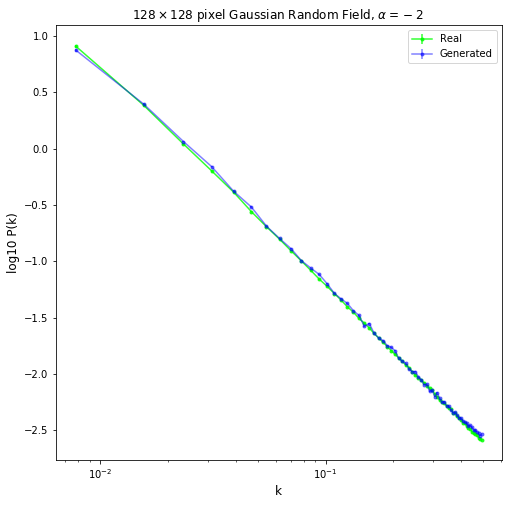

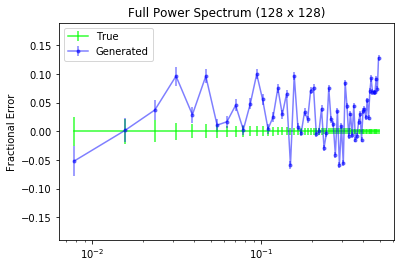

In [5]:

# log power spectrum first
mean_gen, err_gen = np.mean(np.log10(pspec_gen_vals), axis=0), np.std(np.log10(pspec_gen_vals), axis=0)
mean_true, err_true = np.mean(np.log10(pspec_true_vals), axis=0), np.std(np.log10(pspec_true_vals), axis=0)

plt.figure(figsize=(8, 8))
# plt.title('Power Spectrum (64 x 64)')
plt.title('$128 \\times 128$ pixel Gaussian Random Field, $\\alpha=-2$ ', fontsize='large')
plt.errorbar(kr, mean_true, yerr=err_true/np.sqrt(nsamp), marker='.',label='Real', color='lime', alpha=0.8)
plt.errorbar(kg, mean_gen, yerr=err_gen/np.sqrt(nsamp), marker='.', label='Generated', color='b', alpha=0.5)
plt.legend()
plt.ylabel('log10 P(k)', fontsize='large')
plt.xlabel('k', fontsize='large')
plt.xscale('log')
plt.show()


# calculate/plot residual power spectra
mean_gen, err_gen = np.mean(pspec_gen_vals, axis=0), np.std(pspec_gen_vals, axis=0)
mean_true, err_true = np.mean(pspec_true_vals, axis=0), np.std(pspec_true_vals, axis=0)


plt.figure()
# plt.title('Power Spectrum (64 x 64)')
plt.title('Full Power Spectrum (128 x 128)')
plt.errorbar(kr, mean_true-mean_true, yerr=err_true/mean_true/np.sqrt(nsamp), color='lime',alpha=0.8, label='True')
plt.errorbar(kg, (mean_gen-mean_true)/mean_true, marker='.',yerr=err_gen/mean_true/np.sqrt(nsamp) ,alpha=0.5, color='b', label='Generated')
plt.legend()
plt.ylim(-0.19, 0.19)
plt.xscale('log')
plt.ylabel('Fractional Error')

plt.show()

In [31]:
from scipy import stats


# KS test on pixel PDF
gen_pdf= np.histogram(gen_grfs[3].flatten())
plt.figure()
plt.title('Pixel PDF (64 x 64)')
gen_pdf, bins, _ = plt.hist(gen_grfs[3].flatten(), bins=50, normed=True, histtype='step', label='Generated')
real_pdf, _, _ = plt.hist(ims[3].flatten(), bins=bins, normed=True, histtype='step', label='True')
plt.legend()
plt.show()
ks, p = stats.ks_2samp(gen_pdf, real_pdf)
print 'Two distributions have KS statistic of '+str(ks)
print 'p-value = '+str(p)

NameError: name 'gen_grfs' is not defined

In [11]:
plt.figure(figsize=(8,4))
plt.suptitle('Convergence of Generator (128 x 128)', y=1.02)
plt.subplot(1,2,1)
plt.plot(samp_range, avs,marker='.')
# plt.ylim(1.2*np.min(avs), 1.2*np.max(np.abs(avs)))
plt.xlabel('Number of Samples')
plt.ylabel('Pixel Mean')

plt.subplot(1,2,2)
plt.plot(samp_range, stds, marker='.')
plt.axhline(stdtrue, label='Truth', linestyle='dashed', color='g')
plt.xlabel('Number of Samples')
plt.ylabel('Pixel Standard Deviation')
# plt.ylim(0, 1.2*np.max(stds))
plt.tight_layout()

plt.legend()
plt.show()

NameError: name 'samp_range' is not defined

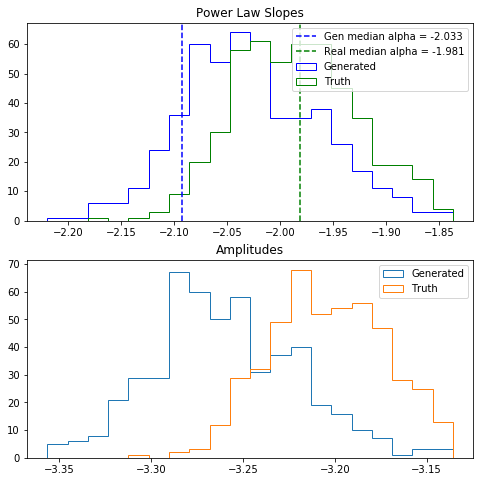

In [18]:
# print slopegen

plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.title('Power Law Slopes')
_, bins, _ = plt.hist(slopegen, label='Generated', color='b', bins=20, histtype='step')
plt.hist(slopereal, label='Truth', bins=bins, color='g', histtype='step')
plt.axvline(np.median(slopegen[slopegen < -1]), linestyle='dashed', color='b', label='Gen median alpha = '+str(np.round(np.median(slopegen), 3)))
plt.axvline(np.median(slopereal), linestyle='dashed', color='g', label='Real median alpha = '+str(np.round(np.median(slopereal), 3)))
plt.legend()

plt.subplot(2,1,2)
plt.title('Amplitudes')
_, bins, _ = plt.hist(ampgen, label='Generated', bins=20, histtype='step')
plt.hist(ampreal, label='Truth', bins=bins, histtype='step')
plt.legend()
# plt.savefig(fpath+'/power_spec_param_estimates.pdf', bbox_inches='tight')
plt.show()

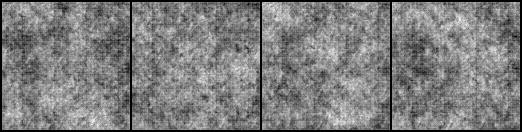

In [17]:
idxs = ['0', '2', '4', '6', '8', '10', '12']
# for idx in idxs:
#     print idx
#     Image('results/20190324-213851/frames/fake/fake_samples_i_001.png') 
# Image('results/20190324-213851/loss_GD.png') 
Image('results/20190324-213851/frames/fake/fake_samples_i_1601.png') 
